<a href="https://colab.research.google.com/github/RyanChen12035/capstone/blob/main/two_tower_demo_TSMC_IT_BSID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.8.0 --quiet
!pip install transformers==4.15.0 --quiet
!pip install faiss-gpu --quiet
# !pip install faiss-cpu --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 19.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer, TFBertModel

In [3]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# download the model from google drive.
from tensorflow.keras.models import load_model
custom_objects = {'TFBertModel': TFBertModel}
model_v5data = load_model('./drive/MyDrive/two_tower_bert_v5.h5', custom_objects=custom_objects)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# download the model from hugging face
!pip install transformers huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


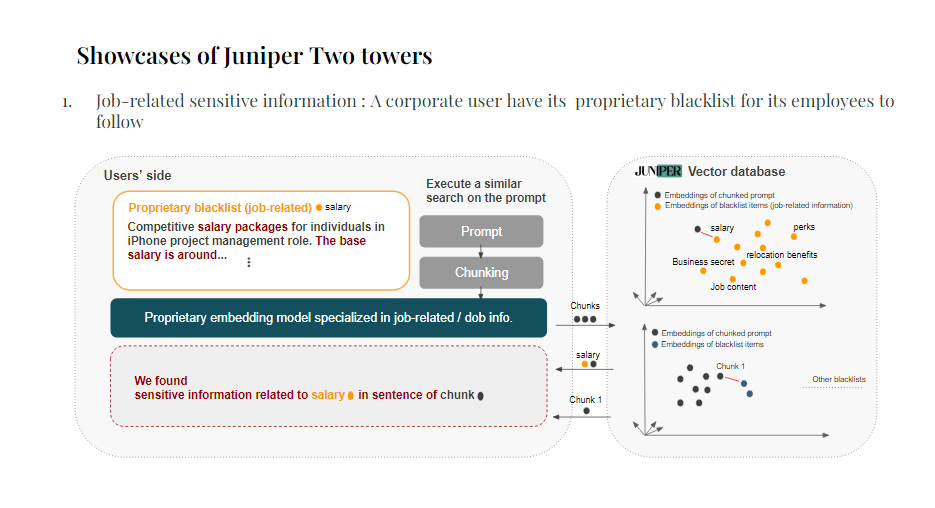

In [5]:
from huggingface_hub import hf_hub_download
from tensorflow.keras.models import load_model
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras import Model

model_path = "Ryanchenucb/two_towers_bert_v5"
file_name = "two_tower_bert_v5.h5"

model_path = hf_hub_download(repo_id=model_path, filename=file_name)
custom_objects = {'TFBertModel': TFBertModel}
model_v5data = load_model(model_path, custom_objects=custom_objects)

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

two_tower_bert_v5.h5:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

Precompute blacklist to the vector database

In [30]:
import numpy as np
# helper functions for cls extraction and translate embeddings to the format of a vector database.
def generate_embedding_cls(text, model):
  bert_embedding_model = Model(inputs=[model.input],
                               outputs=model.get_layer('tf.__operators__.getitem').output)
  bert_train_tokenized = bert_tokenizer(text,
                                        max_length=128,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')
  bert_train_inputs = [bert_train_tokenized.input_ids,
                       bert_train_tokenized.token_type_ids,
                       bert_train_tokenized.attention_mask]
  return bert_embedding_model.predict(bert_train_inputs)


def embedding_vectordatabase(embedding):
  embeddings = np.array(embedding, dtype="float32")
  embeddings = embeddings.reshape(-1, embeddings.shape[-1])
  return embeddings

In [31]:
# create vector databases
import faiss
import numpy as np

dimension = 768  # Dimension of BERT-base embeddings
index_cls_v5 = faiss.IndexFlatL2(dimension)

In [32]:
# bad at 0, 4, 5, 8, rewrote it
# set dob as item 10

level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
                  "Relocation benefits for Apple Cupertino campus positions.",
                  "Exclusive health and wellness benefits for iPhone development team members.",
                  "Stock options and bonuses for iPhone project milestones.",
                  "Providing state-of-the-art collaborative workspaces specifically at Apple's renowned Silicon Valley locations, designed to foster innovation and teamwork among tech professionals.",
                  "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
                  "Confidentiality agreements for upcoming iPhone projects.",
                  "Global travel opportunities for iPhone supplier audits.",
                  "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
                  "Team-building retreats for iPhone project managers."]

for input in level_four_job:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_cls_v5.add(embedding_vectordatabase(embeddings))
print(index_cls_v5.ntotal)

10


Split prompt into sentence-level and do the similar search

In [33]:
job_related_8 = "I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being." #easiest
job_related_4 = "I have a hard time walking to the collaborative workspaces at Apple's Silicon Valley locations."
job_related_7 = "I am traveling to China and will stay there for a couple of weeks for doing supplier audits." #subtly inject the information


prompt = f"""As Jane Cook, I am writing to let my doctor know about my current health status. {job_related_8} Over the past few days,  I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities. My blood pressure is low, but my cholesterol level is normal.
  I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted. My breathing is labored, and I often feel winded after just a few minutes of talking or walking. {job_related_4} The fever has been persistent, and it's making me feel quite uncomfortable.
  Given my symptoms, I am worried that there might be something serious going on with my health. I would greatly appreciate it if you could look into this matter as soon as possible and let me know what is causing these symptoms. My email address is williamsjennifer@example.net, and my phone number is 001-974-704-4096x550. Thank you for your attention to this matter.
  I am looking forward to hearing from you soon. {job_related_7}. Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms."""

In [34]:
import re

def concatenate_short_sentences(sentence_list: list[str], characters_limit: int) -> list[str]:
    concatenated_sentences = []
    i = 0
    while i < len(sentence_list):
        if len(sentence_list[i]) < characters_limit and (i+1) < len(sentence_list):
            concatenated_sentences.append(sentence_list[i] + " " + sentence_list[i+1])
            i += 2
        else:
            concatenated_sentences.append(sentence_list[i])
            i += 1
    return concatenated_sentences

def split_to_sentences(text: str) -> list[str]:
    paragraphs = re.split(r'\n\s*\n', str(text))
    sentences = [re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', para) for para in paragraphs]
    sentence_expanded = [sentence for sublist in sentences for sentence in sublist if len(sentence) > 10 and len(sentence) < 250]
    # concatenate to next if length < 100
    return concatenate_short_sentences(sentence_expanded, 150)

In [35]:
split_to_sentences(prompt)

["As Jane Cook, I am writing to let my doctor know about my current health status. I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
 'Over the past few days,  I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities.',
 'My blood pressure is low, but my cholesterol level is normal.   I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted.',
 "My breathing is labored, and I often feel winded after just a few minutes of talking or walking. I have a hard time walking to the collaborative workspaces at Apple's Silicon Valley locations.",
 "The fever has been persistent, and it's making me feel quite uncomfortable.   Given my symptoms, I am worried that there might be someth

In [36]:
def query_similar_search(query_text: list[str], model, vector_database, k=3) -> list[dict]:
  results = []
  for query in query_text:
    query_embedding = generate_embedding_cls(query, model)
    query_embedding = embedding_vectordatabase(query_embedding)
    distances, indices = vector_database.search(query_embedding, k)

    results.append({
        "query_text": query,
        "distances": distances,
        "indices": indices
    })
  return results

In [37]:
# vectorize it and inference the text by batch to leverage the GPU.
def query_similar_search_batching(query_text: list[str], model, vector_database, k=3) -> list[dict]:

    query_embedding = generate_embedding_cls(query_text, model)
    distances, indices = vector_database.search(query_embedding, k)

    results = []
    for i, query in enumerate(query_text):
        results.append({
        "query_text": query,
        "distances": distances[i],
        "indices": indices[i]
        })

    return results

In [38]:
prompt_sentences = split_to_sentences(prompt)

In [39]:
ss = query_similar_search_batching(prompt_sentences, model_v5data, index_cls_v5, k=3)
ss

[{'query_text': "As Jane Cook, I am writing to let my doctor know about my current health status. I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
  'distances': array([12.386377, 14.239104, 16.75228 ], dtype=float32),
  'indices': array([8, 5, 2])},
 {'query_text': 'Over the past few days,  I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities.',
  'distances': array([644.75714, 650.1165 , 652.74316], dtype=float32),
  'indices': array([4, 1, 8])},
 {'query_text': 'My blood pressure is low, but my cholesterol level is normal.   I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted.',
  'distances': array([577.67096, 580.9273 , 585.0229 ], dtype=float32),
  'indices

In [ ]:
# ss = query_similar_search(prompt_sentences, model_v5data, index_cls_v5, k=3)
# ss

# CPU: 42s (90% of the time is spent on BERT inference)
# GPU T4: 24s (for all chunks) 4s (for the entire prompt without chunking it)
# IVF + GPU T4: 24s
# GPU + batching: 5s
# CPU + batching: 7s

In [40]:
# use the prompt to get an overall retrieval
k=3

query_embedding = generate_embedding_cls(prompt, model_v5data)
query_embedding = embedding_vectordatabase(query_embedding)
distances, indices = index_cls_v5.search(query_embedding, k)

print(distances, indices)

[[33.76567  35.953167 38.05133 ]] [[8 5 6]]


In [41]:
def hint_generator(similar_search: list[dict], threshold) -> dict:
    hint = {}
    for ss_chunks in similar_search:
        items = []
        for i, d in enumerate(ss_chunks['distances']):
            if d < threshold: #found related information
                chunks = ss_chunks['query_text']
                items.append(ss_chunks['indices'][i])
        if items:
            hint[chunks] = items
    return hint
# return a dictionary that saves which chunk contains sensitive information related to which items?

In [42]:
threshold = 500
hint = hint_generator(ss, threshold)
for chunk, item in zip(hint.keys(), hint.values()):
    print(f"We found sensitive information related to item: {item} in the chunk: {chunk}")

# hyperparameter for the sensitivity of two_tower: chunking size, threshold, and blacklist.
# obvious one, distance <50,
# medium one, distance 50~100
# subtle one, distance 100~500
# irrelevant: distance > 600

We found sensitive information related to item: [8, 5, 2] in the chunk: As Jane Cook, I am writing to let my doctor know about my current health status. I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.
We found sensitive information related to item: [1, 6, 4] in the chunk: My breathing is labored, and I often feel winded after just a few minutes of talking or walking. I have a hard time walking to the collaborative workspaces at Apple's Silicon Valley locations.
We found sensitive information related to item: [6, 1, 7] in the chunk: I am traveling to China and will stay there for a couple of weeks for doing supplier audits.. Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms.


# Ana's test examples

In [43]:
# create vector databases
import faiss
import numpy as np

dimension = 768  # Dimension of BERT-base embeddings
index_cls_v5 = faiss.IndexFlatL2(dimension)

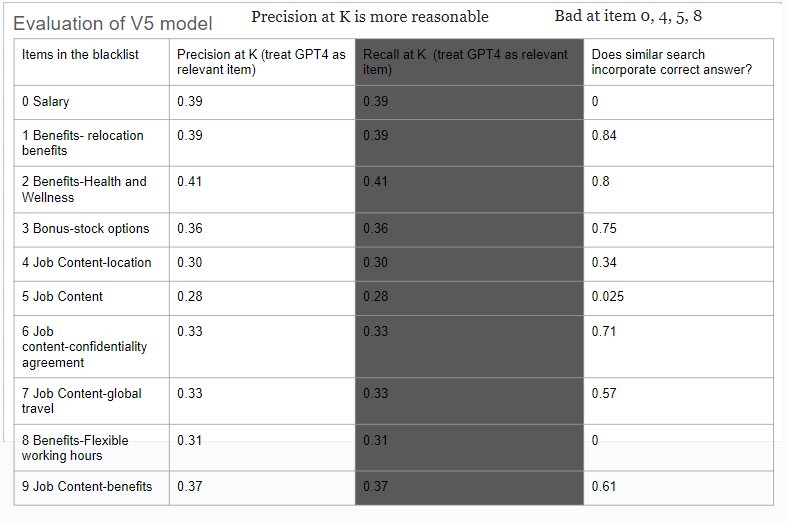

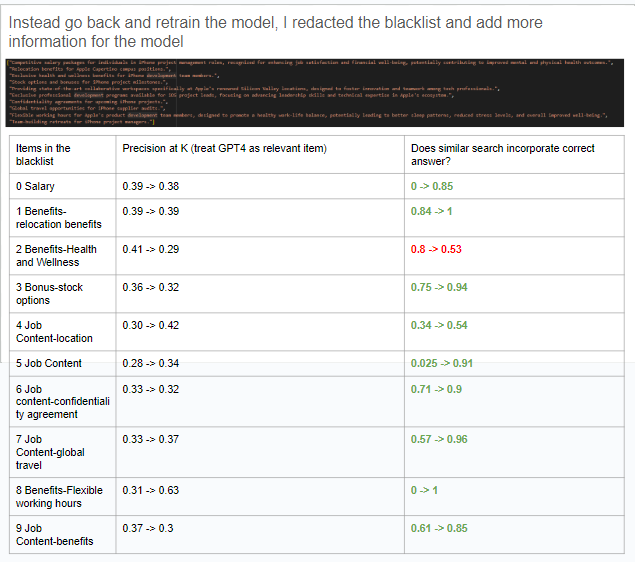

Make contents in the blacklist more explicit to help the similar search process and differ one and another.

In [44]:

# Ask GPT to generate a blaclist for a foot doctor
level_four_job = ["Offers attractive salaries and bonuses for experienced podiatrists, aiming to enhance job satisfaction and financial well-being. Comprehensive health insurance and malpractice insurance included.",
                  "Includes relocation assistance and housing allowance for podiatrists joining prestigious health centers, ensuring a smooth transition to new locations.",
                  "Provides podiatry department staff with access to the latest medical equipment and on-site wellness programs, promoting a healthy work environment.",
                  "Rewards exceptional patient care with bonuses and offers generous funding for continuous education and specialization in podiatry. State-of-the-Art Facilities: Podiatrists will work in ergonomically designed clinics and operating rooms, equipped with advanced podiatric tools for surgeries and treatments.",
                  "Podiatrists will work in ergonomically designed clinics and operating rooms, equipped with advanced podiatric tools for surgeries and treatments.",
                  "Focuses on advancing leadership and technical skills within podiatry, offering specialized programs for career growth.",
                  "Ensures patient privacy and compliance with healthcare privacy laws through training and support in best practices for data protection.",
                  "Offers opportunities to attend international podiatric conferences, facilitating professional networking and exposure to global health initiatives.",
                  "Promotes a healthy work-life balance with options for part-time positions and flexible scheduling, catering to the needs of the medical staff.",
                  "Enhances team dynamics and collaboration through retreats and workshops, fostering innovation and a supportive work culture in podiatry."]

for input in level_four_job:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_cls_v5.add(embedding_vectordatabase(embeddings))
print(index_cls_v5.ntotal)

10


In [45]:
#from Ana

prompt = f"""Dear Dr. Smith,

I hope this message finds you well. My name is Katherine Hahn, and I am a 25-year-old patient born on March 27, 1999. I live at 2097 Bush Coves, New Anthony, CO 46205, and I can be reached at 304-686-8346x989 or via email at christopher40@example.com.

I work as a Chiropodist and am from Israel. I am Hindu and support the Democratic party. I have been experiencing a persistent cough and fatigue recently. My blood pressure and cholesterol levels are within the normal range.

These symptoms have been affecting my day-to-day activities, which typically include assessing, diagnosing, and treating foot and ankle conditions, such as corns, calluses, ingrown toenails, and plantar warts. I also provide advice on foot care, footwear, and orthotics.

I would like to request a follow-up appointment to discuss these symptoms further and explore potential treatment options. Please let me know your availability so we can schedule a convenient time for me to come in.

Thank you for your attention to this matter. I look forward to hearing from you soon.

Warm regards,

Katherine Hahn"""

In [46]:
split_to_sentences(prompt)

['Dear Dr. Smith, I hope this message finds you well.',
 'My name is Katherine Hahn, and I am a 25-year-old patient born on March 27, 1999. I live at 2097 Bush Coves, New Anthony, CO 46205, and I can be reached at 304-686-8346x989 or via email at christopher40@example.com.',
 'I work as a Chiropodist and am from Israel. I am Hindu and support the Democratic party.',
 'I have been experiencing a persistent cough and fatigue recently. My blood pressure and cholesterol levels are within the normal range.',
 'These symptoms have been affecting my day-to-day activities, which typically include assessing, diagnosing, and treating foot and ankle conditions, such as corns, calluses, ingrown toenails, and plantar warts.',
 'I also provide advice on foot care, footwear, and orthotics. I would like to request a follow-up appointment to discuss these symptoms further and explore potential treatment options.',
 'Please let me know your availability so we can schedule a convenient time for me to com

In [47]:
prompt_sentences = split_to_sentences(prompt)
ss = query_similar_search(prompt_sentences, model_v5data, index_cls_v5, k=3)
ss

[{'query_text': 'Dear Dr. Smith, I hope this message finds you well.',
  'distances': array([[733.7967 , 734.79175, 737.0455 ]], dtype=float32),
  'indices': array([[6, 1, 9]])},
 {'query_text': 'My name is Katherine Hahn, and I am a 25-year-old patient born on March 27, 1999. I live at 2097 Bush Coves, New Anthony, CO 46205, and I can be reached at 304-686-8346x989 or via email at christopher40@example.com.',
  'distances': array([[535.23236, 536.8525 , 545.88477]], dtype=float32),
  'indices': array([[1, 6, 9]])},
 {'query_text': 'I work as a Chiropodist and am from Israel. I am Hindu and support the Democratic party.',
  'distances': array([[41.987576, 44.165726, 46.09533 ]], dtype=float32),
  'indices': array([[8, 9, 7]])},
 {'query_text': 'I have been experiencing a persistent cough and fatigue recently. My blood pressure and cholesterol levels are within the normal range.',
  'distances': array([[538.3842 , 543.236  , 552.02405]], dtype=float32),
  'indices': array([[1, 6, 9]])},

In [49]:
def hint_generator(similar_search: list[dict], threshold: float) -> dict:
    hint = {}
    for ss_chunks in similar_search:
        items = []
        chunks = ss_chunks['query_text']
        for i, d in enumerate(ss_chunks['distances'][0]):  # Access the first element of the array
            if d < threshold:  # found related information
                items.append(ss_chunks['indices'][0][i])  # Access the first element of the array
        if items:
            hint[chunks] = items
    return hint

In [51]:
threshold = 400
hint = hint_generator(ss, threshold)
for chunk, item in zip(hint.keys(), hint.values()):
    print(f"We found sensitive information related to item: {item} in the chunk: {chunk}")


# hyperparameter for the sensitivity of two_tower: chunking size, threshold, and blacklist.
# obvious one, distance <50,
# medium one, distance 50~100
# subtle one, distance 100~500
# irrelevant: distance > 600

We found sensitive information related to item: [8, 9, 7] in the chunk: I work as a Chiropodist and am from Israel. I am Hindu and support the Democratic party.
We found sensitive information related to item: [1, 6, 8] in the chunk: These symptoms have been affecting my day-to-day activities, which typically include assessing, diagnosing, and treating foot and ankle conditions, such as corns, calluses, ingrown toenails, and plantar warts.
We found sensitive information related to item: [6, 8, 7] in the chunk: I also provide advice on foot care, footwear, and orthotics. I would like to request a follow-up appointment to discuss these symptoms further and explore potential treatment options.


Inverted file system, using K-mean to get a centroid of the cluster. Search the centroid first and retrieve the data points in the cluster only to speed up the similar search.

In [ ]:
level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
                  "Relocation benefits for Apple Cupertino campus positions.",
                  "Exclusive health and wellness benefits for iPhone development team members.",
                  "Stock options and bonuses for iPhone project milestones.",
                  "Providing state-of-the-art collaborative workspaces specifically at Apple's renowned Silicon Valley locations, designed to foster innovation and teamwork among tech professionals.",
                  "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
                  "Confidentiality agreements for upcoming iPhone projects.",
                  "Global travel opportunities for iPhone supplier audits.",
                  "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
                  "Team-building retreats for iPhone project managers."]


In [ ]:
import faiss

dimension = 768
nlist = 5
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)

embeddings_list = [generate_embedding_cls(text, model_v5data) for text in level_four_job]
embeddings = np.array(embeddings_list, dtype="float32")
embeddings = embeddings.reshape(-1, embeddings.shape[-1])


if not index_ivf.is_trained:
    index_ivf.train(embeddings)  # 'embeddings' should be a matrix of your embeddings

for input in level_four_job:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_ivf.add(embeddings)

print(index_ivf.ntotal)

In [ ]:
index_ivf.nprobe = 1  # Consider only the closest cluster. before ss

In [ ]:
job_related_8 = "I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being." #easiest
job_related_4 = "I have a hard time walking to the collaborative workspaces at Apple's Silicon Valley locations."
job_related_7 = "I am traveling to China and will stay there for a couple of weeks for doing supplier audits." #subtly inject the information



prompt = f"""As Jane Cook, I am writing to let my doctor know about my current health status. {job_related_8} Over the past few days,  I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities. My blood pressure is low, but my cholesterol level is normal.
  I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted. My breathing is labored, and I often feel winded after just a few minutes of talking or walking. {job_related_4} The fever has been persistent, and it's making me feel quite uncomfortable.
  Given my symptoms, I am worried that there might be something serious going on with my health. I would greatly appreciate it if you could look into this matter as soon as possible and let me know what is causing these symptoms. My email address is williamsjennifer@example.net, and my phone number is 001-974-704-4096x550. Thank you for your attention to this matter.
  I am looking forward to hearing from you soon. {job_related_7}. Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms."""

In [ ]:
def query_similar_search_ivf(query_text: list[str], model, vector_database, k=3) -> list[dict]:
  results = []
  for query in query_text:
    query_embedding = generate_embedding_cls(query, model)
    query_embedding = embedding_vectordatabase(query_embedding)
    distances, indices = vector_database.search(query_embedding, k)
    results.append({
        "query_text": query,
        "distances": distances,
        "indices": indices
    })
  return results

In [ ]:
ss = query_similar_search(prompt, model_v5data, index_ivf, k=3)
ss

In [ ]:
prompt_sentences = split_to_sentences(prompt)
ss = query_similar_search(prompt_sentences, model_v5data, index_ivf, k=1)
ss

Test for dob

In [ ]:
# create vector databases
import faiss
import numpy as np

dimension = 768  # Dimension of BERT-base embeddings
index_cls_v5_job_dob = faiss.IndexFlatL2(dimension)

In [ ]:
# bad at 0, 4, 5, 8, rewrote it
# set dob as item 10

level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
                  "Relocation benefits for Apple Cupertino campus positions.",
                  "Exclusive health and wellness benefits for iPhone development team members.",
                  "Stock options and bonuses for iPhone project milestones.",
                  "Providing state-of-the-art collaborative workspaces specifically at Apple's renowned Silicon Valley locations, designed to foster innovation and teamwork among tech professionals.",
                  "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
                  "Confidentiality agreements for upcoming iPhone projects.",
                  "Global travel opportunities for iPhone supplier audits.",
                  "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
                  "Team-building retreats for iPhone project managers.",
                  "I born on March 27, 1999 and my birthday is on March 27."]

for input in level_four_job:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_cls_v5_job_dob.add(embedding_vectordatabase(embeddings))
print(index_cls_v5_job_dob.ntotal)

In [ ]:
job_related_8 = "I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being." #easiest
job_related_4 = "I have a hard time walking to the collaborative workspaces at Apple's Silicon Valley locations."
job_related_7 = "I am traveling to China and will stay there for a couple of weeks for doing supplier audits." #subtly inject the information
dob_10 = "I am 25 years old and I born on March 27, 1999."
dob_10_2 = "I born in 1999 and my birthday is on March 27."


prompt = f"""As Jane Cook, {dob_10} I am writing to let my doctor know about my current health status. {job_related_8} Over the past few days,  I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities. My blood pressure is low, but my cholesterol level is normal.
  I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted. My breathing is labored, and I often feel winded after just a few minutes of talking or walking. {job_related_4} The fever has been persistent, and it's making me feel quite uncomfortable.
  Given my symptoms, I am worried that there might be something serious going on with my health. I would greatly appreciate it if you could look into this matter as soon as possible and let me know what is causing these symptoms. My email address is williamsjennifer@example.net, and my phone number is 001-974-704-4096x550. Thank you for your attention to this matter.
  I am looking forward to hearing from you soon. {job_related_7}. by the way, {dob_10_2} Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms."""

In [ ]:
split_to_sentences(prompt)

In [ ]:
prompt_sentences = split_to_sentences(prompt)

In [ ]:
ss = query_similar_search_batching(prompt_sentences, model_v5data, index_cls_v5_job_dob, k=3)
ss

The model seems confused when we have dob in our blacklist. Create a new blacklist for dob

In [ ]:
dimension = 768  # Dimension of BERT-base embeddings
index_cls_v5_job = faiss.IndexFlatL2(dimension)
index_cls_v5_dob = faiss.IndexFlatL2(dimension)

In [ ]:
level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
                  "Relocation benefits for Apple Cupertino campus positions.",
                  "Exclusive health and wellness benefits for iPhone development team members.",
                  "Stock options and bonuses for iPhone project milestones.",
                  "Providing state-of-the-art collaborative workspaces specifically at Apple's renowned Silicon Valley locations, designed to foster innovation and teamwork among tech professionals.",
                  "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
                  "Confidentiality agreements for upcoming iPhone projects.",
                  "Global travel opportunities for iPhone supplier audits.",
                  "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
                  "Team-building retreats for iPhone project managers."]


for input in level_four_job:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_cls_v5_job.add(embedding_vectordatabase(embeddings))
print(index_cls_v5_job.ntotal)


10


In [ ]:
dob = ["I am Deborah Freeman, 25 years old and I was born on the 27th of March, 1999.",
       "My birth date is March 27, 1999.",
       "It's Deborah Freeman, born on November 18th, 1995",
       "My name is Deborah Freeman and I was born on February 19th, 2000",
       "born on August 31st, 1989. and currently residing at 48568 Perry Divide",
       "born on March 17th, 1984. You can find me at 9141 Powell Valley Apt.",
       "born on June 13, 1986, so that makes me 38 years young"]


for input in dob:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_cls_v5_dob.add(embedding_vectordatabase(embeddings))
print(index_cls_v5_dob.ntotal)

7


In [ ]:
job_related_8 = "I've been having flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being." #easiest
job_related_4 = "I have a hard time walking to the collaborative workspaces at Apple's Silicon Valley locations."
job_related_7 = "I am traveling to China and will stay there for a couple of weeks for doing supplier audits." #subtly inject the information
dob_10 = "I am 25 years old and I born on March 27, 1999."
dob_10_2 = "I born in 1999 and my birthday is on March 27."


prompt = f"""As Jane Cook, {dob_10} I am writing to let my doctor know about my current health status. {job_related_8} Over the past few days,  I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities. My blood pressure is low, but my cholesterol level is normal.
  I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted. My breathing is labored, and I often feel winded after just a few minutes of talking or walking. {job_related_4} The fever has been persistent, and it's making me feel quite uncomfortable.
  Given my symptoms, I am worried that there might be something serious going on with my health. I would greatly appreciate it if you could look into this matter as soon as possible and let me know what is causing these symptoms. My email address is williamsjennifer@example.net, and my phone number is 001-974-704-4096x550. Thank you for your attention to this matter.
  I am looking forward to hearing from you soon. {job_related_7} Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms. By the way, {dob_10_2}"""

In [ ]:
prompt = f"""
Feeling extremely fatigued and overwhelmed at the moment, Sharon Thomas here, born on October 09, 1974, residing at 6831 Julie Avenue, Johnsonhaven, HU 82741. I work as a Civil engineer, consulting, and I am from Bosnia and Herzegovina, practicing Hinduism. My email is johnsoncynthia@example.net and phone number is +1-301-634-5114x4550. Last vacation was on July 15, 2021. Support the Guatemalan National Revolutionary Unity. Blood pressure and cholesterol levels are normal.
 As a civil engineer consultant, my day-to-day activities involve conducting site visits to assess ongoing construction projects, collaborating with architectural teams to develop building plans, and reviewing blueprints for compliance with building codes and regulations. I also spend time meeting with clients to discuss project requirements and deadlines, as well as presenting proposals for new projects.

"""

In [ ]:
import re

def concatenate_short_sentences(sentence_list: list[str], characters_limit: int) -> list[str]:
    concatenated_sentences = []
    i = 0
    while i < len(sentence_list):
        if len(sentence_list[i]) < characters_limit and (i+1) < len(sentence_list):
            concatenated_sentences.append(sentence_list[i] + " " + sentence_list[i+1])
            i += 2
        else:
            concatenated_sentences.append(sentence_list[i])
            i += 1
    return concatenated_sentences

def split_to_sentences_dob(text: str) -> list[str]:
    paragraphs = re.split(r'\n\s*\n', str(text))
    sentences = [re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', para) for para in paragraphs]
    sentence_expanded = [sentence for sublist in sentences for sentence in sublist if len(sentence) > 10 and len(sentence) < 150]
    # concatenate to next if length < 100
    return sentence_expanded

In [ ]:
split_to_sentences_dob(prompt)

['I work as a Civil engineer, consulting, and I am from Bosnia and Herzegovina, practicing Hinduism.',
 'My email is johnsoncynthia@example.net and phone number is +1-301-634-5114x4550.',
 'Last vacation was on July 15, 2021.',
 'Support the Guatemalan National Revolutionary Unity.',
 'Blood pressure and cholesterol levels are normal.',
 'I also spend time meeting with clients to discuss project requirements and deadlines, as well as presenting proposals for new projects.']

In [ ]:
prompt_sentences = split_to_sentences(prompt)

In [ ]:
# Similar search for dob information
ss_dob = query_similar_search_batching(prompt_sentences, model_v5data, index_cls_v5_dob, k=1)
ss_dob

[{'query_text': '\nFeeling extremely fatigued and overwhelmed at the moment, Sharon Thomas here, born on October 09, 1974, residing at 6831 Julie Avenue, Johnsonhaven, HU 82741.',
  'distances': array([48.539845], dtype=float32),
  'indices': array([0])},
 {'query_text': 'I work as a Civil engineer, consulting, and I am from Bosnia and Herzegovina, practicing Hinduism. My email is johnsoncynthia@example.net and phone number is +1-301-634-5114x4550.',
  'distances': array([198.97981], dtype=float32),
  'indices': array([4])},
 {'query_text': 'Last vacation was on July 15, 2021. Support the Guatemalan National Revolutionary Unity.',
  'distances': array([177.57211], dtype=float32),
  'indices': array([4])},
 {'query_text': 'Blood pressure and cholesterol levels are normal. I also spend time meeting with clients to discuss project requirements and deadlines, as well as presenting proposals for new projects.',
  'distances': array([207.90671], dtype=float32),
  'indices': array([4])}]

In [ ]:
threshold = 80
hint = hint_generator(ss_dob, threshold)
for chunk, item in zip(hint.keys(), hint.values()):
    print(f"We found date of birth in the chunk: {chunk}")

We found date of birth in the chunk: 
Feeling extremely fatigued and overwhelmed at the moment, Sharon Thomas here, born on October 09, 1974, residing at 6831 Julie Avenue, Johnsonhaven, HU 82741.


In [ ]:
"""
Sample that passed the dob test

Hey there! It's Deborah Freeman, born on February 19th, 1999 and currently residing at 097 Joseph Vista in Walshfurt, TG 00632. I'm a Colour technologist by profession and have been feeling quite under the weather lately with persistent coughing and fatigue. My last vacation was back in July to Zambia - such an amazing experience! Despite that, my blood pressure is normal at 120/80 mmHg and cholesterol level is within the healthy range too. Anyways, I'm feeling pretty drained today with a bit of body aches as well. Hopefully, it's just a passing phase! Closing sentence: Off to rest now and hope for a speedy recovery!



Hey there! It's me, Martha Nelson, and I'm feeling pretty rough lately. My cough has been persistent for weeks now, and I've been experiencing fatigue that just won't go away. Despite my normal blood pressure and cholesterol levels, I can't seem to shake off this lingering tiredness. It's like I'm constantly running on empty!

I last went on vacation back in August to explore the beautiful islands of Comoros. It was such a wonderful experience, but now it feels like a distant memory. My body just doesn't feel like itself anymore.

Anyway, that's me for now - Martha Nelson, 25 years old from Port Brian, VA (born on January 29th, 1999). You can reach me at matthew09@example.net or give me a call at 990.739.9100 ext. 710 if you want to chat more about my symptoms!

Oh, and did I mention that I'm Muslim and support the Democratic Rally of the Comoros? It's important to me to stay true to my roots and beliefs while seeking medical attention. So, any doctor



Hey there, it's Kenneth Parker here! Born on August 10th, 1986 and currently residing at 221 Catherine Vista in West Jasonport, CZ 81268. You can reach me via email at deannagarcia@example.org or give me a ring at 790-469-6458. I'm feeling pretty rough these days, gotta say! Been dealing with some serious fatigue and a persistent cough that just won't go away. Oh, and let's not forget the fever - it's been hanging around for weeks now! My blood pressure is through the roof too, which only makes things worse.
     Last time I went on vacation was back in February to Thailand, where I definitely didn't need any of these symptoms! But hey, life happens, right? Anyways, that's me for now - hope you're doing better than I am!



Hey there, it's Charles Schneider here! *yawn* Sorry about that, I'm feeling pretty tired today. It's been a while since my last vacation on February 20th, and I could really use another break from work. As a GIS officer, I spend most of my days staring at screens and crunching numbers - it can be draining, you know? *sigh*

Anyway, enough about that. My blood pressure has been a bit high lately, and I've been experiencing some fatigue too. Oh well, I guess that comes with the territory of getting older, right? At least my cholesterol levels are normal - gotta look at the bright side! *smile*

So yeah, it's Charles Schneider here, born on March 17th, 1984. You can find me at 9141 Powell Valley Apt. 860 in Aguirrehaven, DO 39387. My email address is murphygregory@example.org and my phone number is 001-976-925-9528x184. I'm a Muslim dude from the Dominican Republic, supporting the Popular Action Bloc -


I am responsible for managing and analyzing geospatial data in my role as a GIS Officer at the local government department of transportation. My primary duties include maintaining and updating the department's spatial databases, creating maps and reports using ArcGIS software, and providing technical support to other departments within the organization.

Today, I am working on a new project to develop a real-time traffic management system that will use GPS data from vehicles to monitor and optimize traffic flow. This involves integrating data from various sources such as sensors, cameras, and social media feeds into our GIS platform. Additionally, I am collaborating with other departments within the organization to ensure that the new system meets their needs and is compatible with existing infrastructure.

To accomplish these tasks, I spend most of my day working with ArcGIS software, writing Python scripts to automate data processing and analysis, and communicating with stakeholders across the department. In the afternoon, I will attend a meeting with representatives from other departments to discuss the project's progress and plan for future development.



Hey there! It's Rebecca Bradley here, born on May 07, 1989. I'm feeling pretty rough lately with a persistent cough and fatigue that just won't go away. My breathing has also been a bit difficult. Other than that, my blood pressure is normal but my cholesterol levels are through the roof! It's crazy because I thought I was eating healthy, but I guess not so much after all.
     Oh, and I just got back from an amazing vacation in Bali last month - it was such a relaxing getaway! But now that I'm home, I can really feel the effects of my symptoms taking their toll on me. It's hard to focus at work when all I want to do is sleep all day.
     Anyways, enough about that for now. Just thought I'd drop you a line and let you know what's going on with me. Hopefully, these symptoms will pass soon so I can get back to my usual self! Talk to you later!


As an international aid/development worker, my day-to-day activities involve a range of tasks aimed at improving the lives of communities in developing countries. I spend time conducting needs assessments to identify priority areas for intervention, designing and implementing projects to address these issues, and monitoring and evaluating the impact of our work.

Recently, we have been working on introducing a new water filtration system to a community that has limited access to clean drinking water. This has involved conducting surveys to understand the community's needs, designing and installing the filtration systems, and training local residents on how to maintain them. The response from the community has been overwhelmingly positive, with many reporting improved health and increased productivity as a result of having access to clean water.


Feeling extremely fatigued and overwhelmed at the moment, Sharon Thomas here, born on October 09, 1974, residing at 6831 Julie Avenue, Johnsonhaven, HU 82741. I work as a Civil engineer, consulting, and I am from Bosnia and Herzegovina, practicing Hinduism. My email is johnsoncynthia@example.net and phone number is +1-301-634-5114x4550. Last vacation was on July 15, 2021. Support the Guatemalan National Revolutionary Unity. Blood pressure and cholesterol levels are normal.
 As a civil engineer consultant, my day-to-day activities involve conducting site visits to assess ongoing construction projects, collaborating with architectural teams to develop building plans, and reviewing blueprints for compliance with building codes and regulations. I also spend time meeting with clients to discuss project requirements and deadlines, as well as presenting proposals for new projects.


"""